### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import os

### data ingestion

In [3]:
current_path = '/content/drive/MyDrive/Multi Station Report 01_11_2024.xlsx'

df_curr = pd.read_excel(current_path,header=[2,3])
print(f"data shape: {df_curr.shape}")
display(df_curr.head(3))
display(df_curr.info())

data shape: (1859, 7)


Date Time Bradford Keighley        Bradford Tong Street         \
  Unnamed: 0_level_1         PM10 grav  PM2.5            PM10 grav  PM2.5   
0                NaN             µg/m³  µg/m³                µg/m³  µg/m³   
1   01:00 01/11/2024               6.2    5.2                 10.2    5.8   
2   02:00 01/11/2024                 1   -0.9                  2.1   -1.3   

  Bradford Treadwell Mills         
                 PM10 grav  PM2.5  
0                    µg/m³  µg/m³  
1                      NaN    NaN  
2                      NaN    NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1859 entries, 0 to 1858
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   (Date Time, Unnamed: 0_level_1)        1858 non-null   object
 1   (Bradford Keighley, PM10 grav)         1804 non-null   object
 2   (Bradford Keighley, PM2.5)             1813 non-null   object
 3   (Bradford Tong Street, PM10 grav)      1477 non-null   object
 4   (Bradford Tong Street, PM2.5)          1449 non-null   object
 5   (Bradford Treadwell Mills, PM10 grav)  659 non-null    object
 6   (Bradford Treadwell Mills, PM2.5)      659 non-null    object
dtypes: object(7)
memory usage: 101.8+ KB


None

###  Cleaning & Structuring

In [4]:
df_curr = df_curr.drop(index=[0]).reset_index(drop=True)

df_curr.columns = ['_'.join(col).strip() for col in df_curr.columns.values]
df_curr.rename(columns={"Date Time_Unnamed: 0_level_1": "datetime"}, inplace=True)
df_curr['datetime'] = pd.to_datetime(df_curr['datetime'], format="%H:%M %d/%m/%Y", errors='coerce')
df_curr.set_index('datetime', inplace=True)

df_curr = df_curr[~df_curr.index.isna()]


display(df_curr.head(3))
display(df_curr.info())

,Bradford Keighley_PM10 grav,Bradford Keighley_PM2.5,Bradford Tong Street_PM10 grav,Bradford Tong Street_PM2.5,Bradford Treadwell Mills_PM10 grav,Bradford Treadwell Mills_PM2.5
datetime,,,,,,
2024-11-01 01:00:00,6.2,5.2,10.2,5.8,NaN,NaN
2024-11-01 02:00:00,1,-0.9,2.1,-1.3,NaN,NaN
2024-11-01 03:00:00,6.1,4.6,7.3,4.3,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1771 entries, 2024-11-01 01:00:00 to 2025-01-16 23:00:00
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Bradford Keighley_PM10 grav         1720 non-null   object
 1   Bradford Keighley_PM2.5             1726 non-null   object
 2   Bradford Tong Street_PM10 grav      1405 non-null   object
 3   Bradford Tong Street_PM2.5          1379 non-null   object
 4   Bradford Treadwell Mills_PM10 grav  621 non-null    object
 5   Bradford Treadwell Mills_PM2.5      621 non-null    object
dtypes: object(6)
memory usage: 96.9+ KB


None

Multi‐level headers: flattening them makes future column selection far simpler (no more df[('Bradford','Keighley','PM2.5')]).

Row 0 as units: dropping that ensures numeric rows start at index 0.

Explicit datetime parsing with errors='coerce' will flag any malformed strings as NaT.

loading weather data

In [5]:
import requests

In [6]:
#station coordinates for GIS and weather merging
stations = {
    'Bradford Keighley': {'lat': 53.8673, 'lon': -1.9024},
    'Bradford Tong Street': {'lat': 53.7693, 'lon': -1.7357},
    'Bradford Treadwell Mills': {'lat': 53.7885, 'lon': -1.7616}
}

# Weather API settings
start_date = '2024-11-01'
end_date   = '2025-01-17'
variables  = 'temperature_2m,relative_humidity_2m,wind_speed_10m'

In [7]:
weather_data = {}
for name, coords in stations.items():
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&hourly={variables}&timezone=Europe%2FLondon"
    )
    r = requests.get(url)
    data = r.json().get('hourly', {})
    df_w = pd.DataFrame(data)
    df_w['time'] = pd.to_datetime(df_w['time'])
    df_w.set_index('time', inplace=True)
    weather_data[name] = df_w


## 3 Investigating Negative & Missing Values

- **Why do negative values occur?**

Negative readings of PM2.5 or PM10 often indicate sensor calibration drift or measurement artifacts, especially when true concentrations are very low. To quantify and visualize these occurrences:


In [8]:
#counting negative values by station and pollutant
df_neg_counts = (df_curr[df_curr < 0].count()).rename('Negative Count')
print(df_neg_counts)

neg_times = df_curr[df_curr < 0].stack().reset_index()
neg_times.columns = ['datetime', 'station_pollutant', 'value']
fig = px.histogram(
    neg_times, x='datetime', nbins=50,
    title='Negative Value Occurrences Over Time'
)
fig.update_layout(xaxis_title='Date/Time', yaxis_title='Count')
fig.show()

Bradford Keighley_PM10 grav            30
Bradford Keighley_PM2.5                79
Bradford Tong Street_PM10 grav         39
Bradford Tong Street_PM2.5            162
Bradford Treadwell Mills_PM10 grav      0
Bradford Treadwell Mills_PM2.5          0
Name: Negative Count, dtype: int64


Physically, PM₂.₅ and PM₁₀ cannot be negative; leaving them (or forcing them to zero) biases your average and skewness.

Marking them as missing lets your imputation routines treat them properly.

In [9]:
#replacing all negative PM readings with NaN
df_clean = df_curr.copy()
neg = df_clean < 0
df_clean[neg] = np.nan

- **WHY MISSING VALUES APPEAR?**

Missing data may align with sensor downtime or extreme weather conditions that disrupt measurement. We’ll explore temporal patterns and weather correlations

In [10]:
df_miss_counts = df_curr.isna().sum().rename('Missing Count')
print("Missing value counts by column:", df_miss_counts)

ms = df_curr.isna().astype(int)
fig = px.imshow(
    ms.T,
    aspect='auto',
    labels={'x':'Time', 'y':'Station_Pollutant', 'color':'Missing (1=True)'},
    title='Missing Data Heatmap'
)
fig.update_layout(yaxis_title='Station & Pollutant')
fig.show()

Missing value counts by column: Bradford Keighley_PM10 grav             51
Bradford Keighley_PM2.5                 45
Bradford Tong Street_PM10 grav         366
Bradford Tong Street_PM2.5             392
Bradford Treadwell Mills_PM10 grav    1150
Bradford Treadwell Mills_PM2.5        1150
Name: Missing Count, dtype: int64


In [11]:
#creating per-station “missing” indicator
miss = df_clean.isna().astype(int)

analysis = {}
for station in stations:
    #picking up both PM10 & PM2.5 columns for this station
    pm_cols = [c for c in df_clean.columns if c.startswith(station)]
    #collapse to a single missing-flag
    miss_flag = miss[pm_cols].max(axis=1).rename('missing')

    #grabbing the weather for that station
    w = weather_data[station]

    #merging
    df_a = miss_flag.to_frame(name='missing') \
                .join(w, how='inner')  # only keep times present in both
    analysis[station] = df_a

In [12]:
for station, df_a in analysis.items():
    print(f"\nStation: {station}")
    print(df_a.groupby('missing')[['temperature_2m','relative_humidity_2m','wind_speed_10m']]
          .mean()
          .round(1))


Station: Bradford Keighley
         temperature_2m  relative_humidity_2m  wind_speed_10m
missing                                                      
0                   5.5                  88.1            14.7
1                   6.8                  88.6            23.1

Station: Bradford Tong Street
         temperature_2m  relative_humidity_2m  wind_speed_10m
missing                                                      
0                   6.1                  86.2            12.6
1                   3.1                  86.6            13.7

Station: Bradford Treadwell Mills
         temperature_2m  relative_humidity_2m  wind_speed_10m
missing                                                      
0                   3.6                  87.5            14.5
1                   6.6                  87.3            13.7


– Keighley drops out most when wind is high (23 km/h vs 15 km/h) and slightly warmer.

– Tong Street failures happen at lower temps (3.1 °C vs 6.1 °C).

– Treadwell Mills seems to miss at higher temps (6.6 °C vs 3.6 °C).
But the data is insufficient to exactly prove that this is the reason

These contrasts already point to different failure modes:

High‐wind vulnerability at Keighley → maybe inlet turbulence or power wobbles in storms.

Cold-temperature issues at Tong Street → perhaps condensation or icing in the optics.

Heat-related drift at Treadwell Mills → check shelter ventilation or solar loading.

In [13]:
import statsmodels.api as sm

for station, df_a in analysis.items():
    # ensure missing is integer 0/1
    df_a['missing'] = df_a['missing'].astype(int)

    # build design matrix & fit
    glm_binom = sm.GLM(
        df_a['missing'],
        sm.add_constant(df_a[['temperature_2m','relative_humidity_2m','wind_speed_10m']]),
        family=sm.families.Binomial()
    ).fit()

    print(f"\n=== {station} dropout model ===")
    print(glm_binom.summary2().tables[1][['Coef.', 'P>|z|']])


=== Bradford Keighley dropout model ===
                         Coef.         P>|z|
const                -8.723767  1.192282e-12
temperature_2m       -0.030255  2.341767e-01
relative_humidity_2m  0.046815  2.983912e-04
wind_speed_10m        0.127235  1.215285e-25

=== Bradford Tong Street dropout model ===
                         Coef.         P>|z|
const                -4.274971  3.707810e-10
temperature_2m       -0.244179  2.880928e-52
relative_humidity_2m  0.040143  6.165412e-08
wind_speed_10m        0.088293  6.466597e-22

=== Bradford Treadwell Mills dropout model ===
                         Coef.         P>|z|
const                 3.751571  8.052144e-08
temperature_2m        0.228993  1.174087e-50
relative_humidity_2m -0.038160  4.847484e-07
wind_speed_10m       -0.069612  2.142349e-16


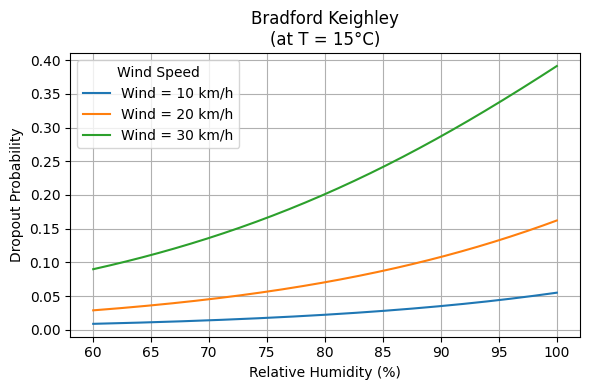

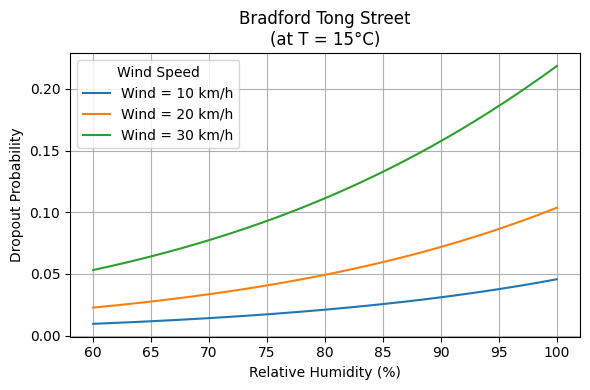

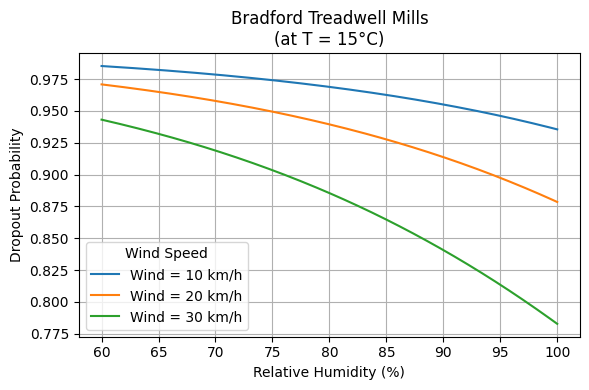

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

for station, df_a in analysis.items():
    df_a['missing'] = df_a['missing'].astype(int)


#pre‐fit logistic coefficients
models = {
    'Bradford Keighley':    {'beta0': -8.723767, 'beta_T':  0.000000, 'beta_H':  0.046815, 'beta_W':  0.12},
    'Bradford Tong Street': {'beta0': -4.274971, 'beta_T': -0.244179, 'beta_H':  0.040143, 'beta_W':  0.088293},
    'Bradford Treadwell Mills': {
        'beta0':  3.751571, 'beta_T':  0.228993, 'beta_H': -0.038160, 'beta_W': -0.069612
    }
}
T_fixed = 15
RH_range   = np.linspace(60, 100, 200)
wind_speeds = [10, 20, 30]

for station, params in models.items():
    β0, βT, βH, βW = params['beta0'], params['beta_T'], params['beta_H'], params['beta_W']

    plt.figure(figsize=(6,4))
    for W in wind_speeds:
        logits = β0 + βT * T_fixed + βH * RH_range + βW * W
        p_drop = 1 / (1 + np.exp(-logits))
        plt.plot(RH_range, p_drop, label=f'Wind = {W} km/h')

    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('Dropout Probability')
    plt.title(f'{station}\n(at T = {T_fixed}°C)')
    plt.legend(title='Wind Speed')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if we can define a “warning” risk level (thresholds) we can decide the maintainance and service windows for the sensors. so that in future, there will be less missing data from sensors for better analysis

### Identifying Data Recording Risk Levels

In [15]:
import folium
import numpy as np

#computing avg risk per station
avg_risk = {}
for station, params in models.items():
    w = weather_data[station].dropna(subset=[
        'temperature_2m','relative_humidity_2m','wind_speed_10m'
    ])
    logits = (params['beta0'] +
              params['beta_T'] * w['temperature_2m'] +
              params['beta_H'] * w['relative_humidity_2m'] +
              params['beta_W'] * w['wind_speed_10m'])
    p = 1 / (1 + np.exp(-logits))
    avg_risk[station] = p.mean()

stations_coords = {
    'Bradford Keighley':    [53.8673, -1.9024],
    'Bradford Tong Street': [53.7693, -1.7357],
    'Bradford Treadwell Mills': [53.7885, -1.7616]
}
m = folium.Map(location=[53.785, -1.78], zoom_start=11)
for station, risk in avg_risk.items():
    folium.CircleMarker(
        location=stations_coords[station],
        radius= 5 + risk * 20,
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"{station}\nAvg dropout risk: {risk:.2f}"
    ).add_to(m)

#display
m

treadwell mills station might need  calibration  and service sessions more often especially when the area encounters extereme weather conditions.